# Random Forest Classification Long Only Strategy

## Import Data

In [132]:
# Data manipulation
import numpy as np
import pandas as pd

# Technical indicators
import talib as ta

import yfinance as yf

# Plotting the graphs
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
plt.style.use('seaborn-darkgrid')

# Machine learning
from sklearn.ensemble import RandomForestClassifier
from sklearn import metrics
import pyfolio as pf

In [133]:
data = yf.download('MSFT')
data

[*********************100%***********************]  1 of 1 completed


,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
1986-03-13,0.088542,0.101563,0.088542,0.097222,0.061109,1031788800
1986-03-14,0.097222,0.102431,0.097222,0.100694,0.063292,308160000
1986-03-17,0.100694,0.103299,0.100694,0.102431,0.064384,133171200
1986-03-18,0.102431,0.103299,0.098958,0.099826,0.062746,67766400
1986-03-19,0.099826,0.100694,0.097222,0.098090,0.061655,47894400
...,...,...,...,...,...,...
2022-06-13,245.110001,249.020004,241.529999,242.259995,242.259995,46135800
2022-06-14,243.860001,245.740005,241.509995,244.490005,244.490005,28651500
2022-06-15,248.309998,255.300003,246.419998,251.759995,251.759995,33111700


<AxesSubplot:xlabel='Date'>

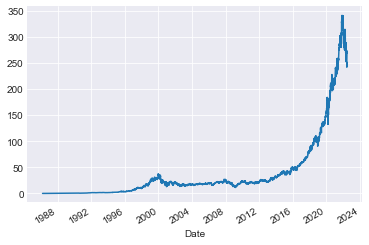

In [134]:
data['Adj Close'].plot()

## Extract X-y pair

In [160]:
def get_target_features(data):    
    data['returns'] = data['Adj Close'].pct_change()
    
    # RSI
    data['rsi'] = ta.RSI(data['Adj Close'].values, timeperiod=14)

    # ADX
    data['adx'] = ta.ADX(data['High'].values, data['Low'].values, data['Open'].values, timeperiod=14)
    
    # SMA
    data['sma'] = data['Adj Close'].rolling(window=14).mean()

    # Correlation
    data['corr'] = data['Adj Close'].rolling(window=14).corr(data['sma'])
    
    # Volatility
    data['volatility'] = data.rolling(14)['returns'].std()*100

    # Create the signal column
    data['signal'] = np.where(data['returns'].shift(-1) > 0, 1, 0)
    
    data = data.dropna()

    return data['signal'], data[['returns', 'rsi', 'adx', 'corr', 'volatility']]

In [161]:
y, X = get_target_features(data)

## Split the data to training and testing sets

In [162]:
split = int(0.7*len(X))
X_train, X_test, y_train, y_test = X[:split], X[split:], y[:split], y[split:]

## Scale the Data

In [137]:
from sklearn.preprocessing import StandardScaler
sc = StandardScaler()

X_test_original = X_test.copy()

X_train = sc.fit_transform(X_train)
X_test = sc.fit_transform(X_test)

## Fit the Model

In [138]:
clf = RandomForestClassifier(random_state=5, max_depth=3, max_features=3)

# Create the model on train dataset
model = clf.fit(X_train, y_train)

## Evaluate the Model

In [139]:
def get_metrics(y_test, predicted):
    confusion_matrix_data = metrics.confusion_matrix(y_test, predicted)
    # Plot the data

    fig, ax = plt.subplots(figsize=(6, 4))
    sns.heatmap(confusion_matrix_data, fmt="d",cmap='Blues', cbar=False, annot=True, ax=ax)

    # Set the axes labels and the title
    ax.set_xlabel('Predicted Labels', fontsize=12)
    ax.set_ylabel('Actual Labels', fontsize=12)
    ax.set_title('Confusion Matrix', fontsize=14)
    ax.xaxis.set_ticklabels(['No Position', 'Long Position'])
    ax.yaxis.set_ticklabels(['No Position', 'Long Position'])

    # Display the plot
    plt.show()

    print(metrics.classification_report(y_test, predicted))


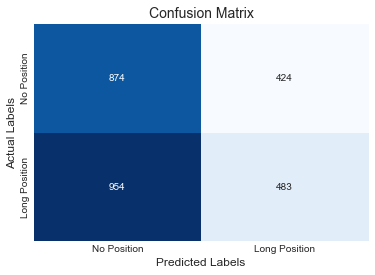

              precision    recall  f1-score   support

           0       0.48      0.67      0.56      1298
           1       0.53      0.34      0.41      1437

    accuracy                           0.50      2735
   macro avg       0.51      0.50      0.49      2735
weighted avg       0.51      0.50      0.48      2735



In [140]:
y_pred = model.predict(X_test)
get_metrics(y_test, y_pred)

## Straetgy Performance Analysis

In [151]:
def plot_equity_curve(strategy_data):
    
    # Calculate the cumulative returns
    strategy_data['strategy_cumulative_returns'] = (1+strategy_data['strategy_returns']).cumprod()
    
    strategy_data['bnh_cumulative_returns'] = (1+strategy_data['returns']).cumprod()

    strategy_data['strategy_cumulative_returns'].plot(figsize=(8, 5), color='green')
    strategy_data['bnh_cumulative_returns'].plot(figsize=(8, 5), color='blue')
    plt.title('Equity Curve', fontsize=14)
    plt.legend()
    plt.ylabel('Cumulative returns')
    plt.tight_layout()
    plt.show()


In [153]:
def sharpe_ratio(strategy_data):
    sharpe_ratio = round(strategy_data['strategy_returns'].mean() / strategy_data['strategy_returns'].std() * np.sqrt(252), 2)
    print("The Sharpe ratio is {0:.2f}.".format(sharpe_ratio))
    

In [152]:
def plot_drawdown(strategy_data):
    
    # Calculate the running maximum
    running_max = np.maximum.accumulate(strategy_data['strategy_cumulative_returns'].dropna())
    # Ensure the value never drops below 1
    running_max[running_max < 1] = 1
    # Calculate the percentage drawdown
    drawdown = ((strategy_data['strategy_cumulative_returns'])/running_max - 1) * 100

    # Calculate the maximum drawdown
    max_dd = drawdown.min()
    print("The maximum drawdown is {0:.2f}%.".format(max_dd))

    fig = plt.figure(figsize=(8, 5))

    # Plot max drawdown
    plt.plot(drawdown, color='red')
    # Fill in-between the drawdown
    plt.fill_between(drawdown.index, drawdown.values, color='red')
    plt.title('Strategy Drawdown', fontsize=14)
    plt.ylabel('Drawdown(%)', fontsize=12)
    plt.xlabel('Year', fontsize=12)

    plt.tight_layout()
    plt.show()

In [154]:
def get_performance(strategy_data):
    plot_equity_curve(strategy_data)
    plot_drawdown(strategy_data)
    sharpe_ratio(strategy_data)

In [155]:
# Calculate the percentage change
strategy_data = X_test_original[['returns']].copy()

# Predict the signals
strategy_data['signal'] = model.predict(X_test)

# Calculate the strategy returns
strategy_data['strategy_returns'] = strategy_data['signal'].shift(1) * strategy_data['returns']

# Drop the missing values
strategy_data.dropna(inplace=True)

strategy_data.head()

,returns,signal,strategy_returns
Date,,,
2011-08-09,0.044935,0,0.044935
2011-08-10,-0.053948,1,-0.000000
2011-08-11,0.040909,0,0.040909
2011-08-12,-0.003573,0,-0.000000
2011-08-15,0.016335,0,0.000000


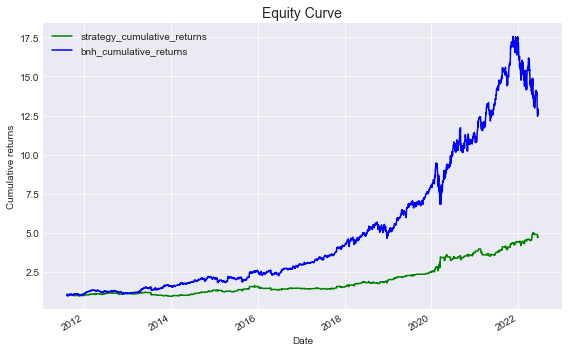

The maximum drawdown is -21.98%.


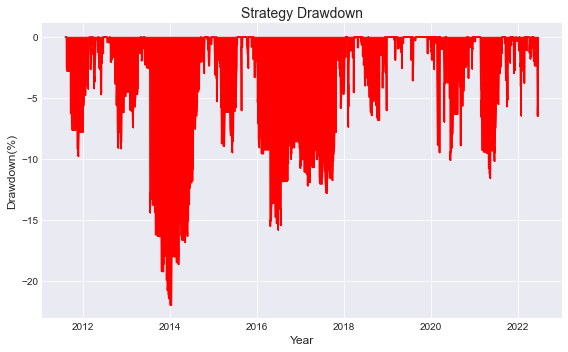

The Sharpe ratio is 0.99.


In [156]:
get_performance(strategy_data)

Start date,2011-08-09
End date,2022-06-17
Total months,130
,Backtest
Annual return,15.5%
Cumulative returns,379.7%
Annual volatility,15.9%
Sharpe ratio,0.99
Calmar ratio,0.71
Stability,0.88
Max drawdown,-22.0%


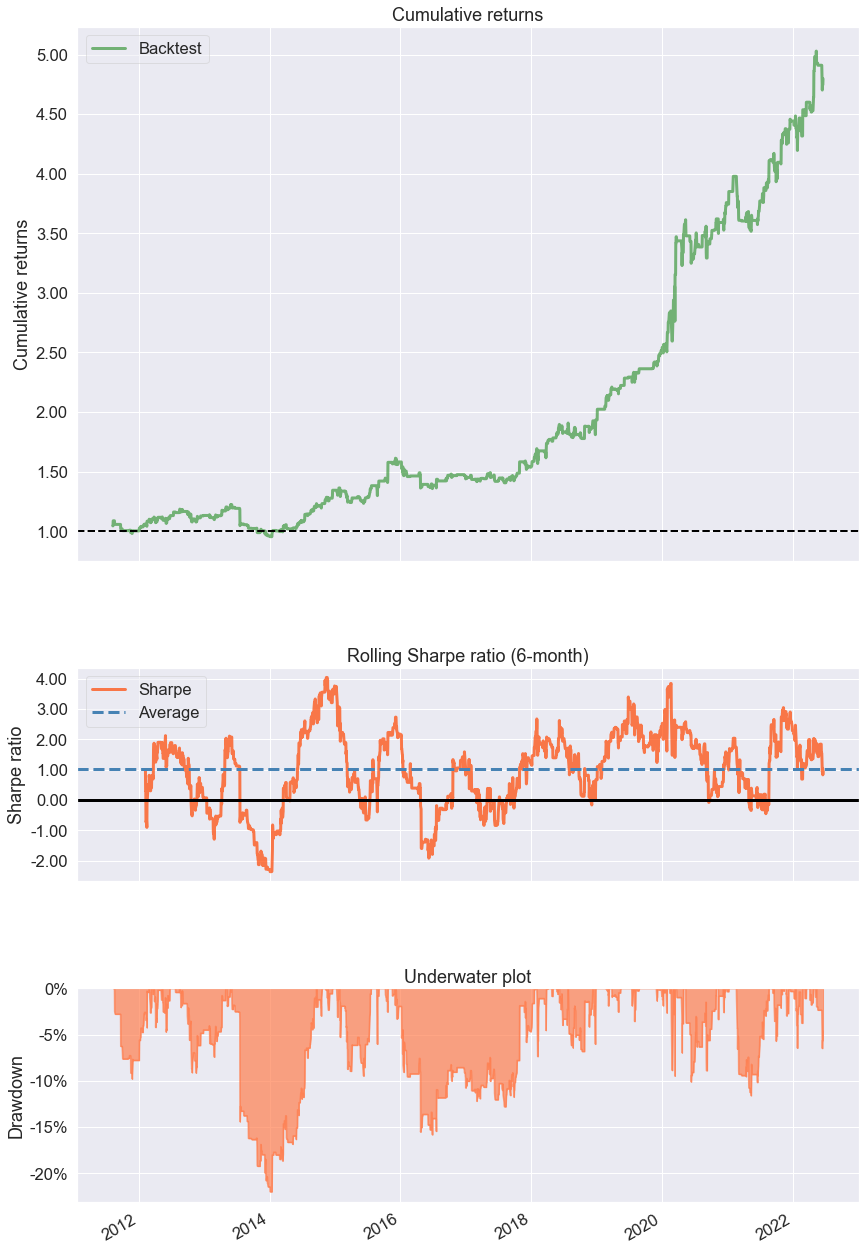

In [157]:
pf.create_simple_tear_sheet(strategy_data['strategy_returns'])